# Contents
## Basics of PyTorch
- Defining network architecture
- Dataset and Dataloader
- Training
- Inference

## Data Augmentation
- Data Augmentation

## Massachusetts Buildings Dataset
In this tutorial, we use the dataset for building detection.

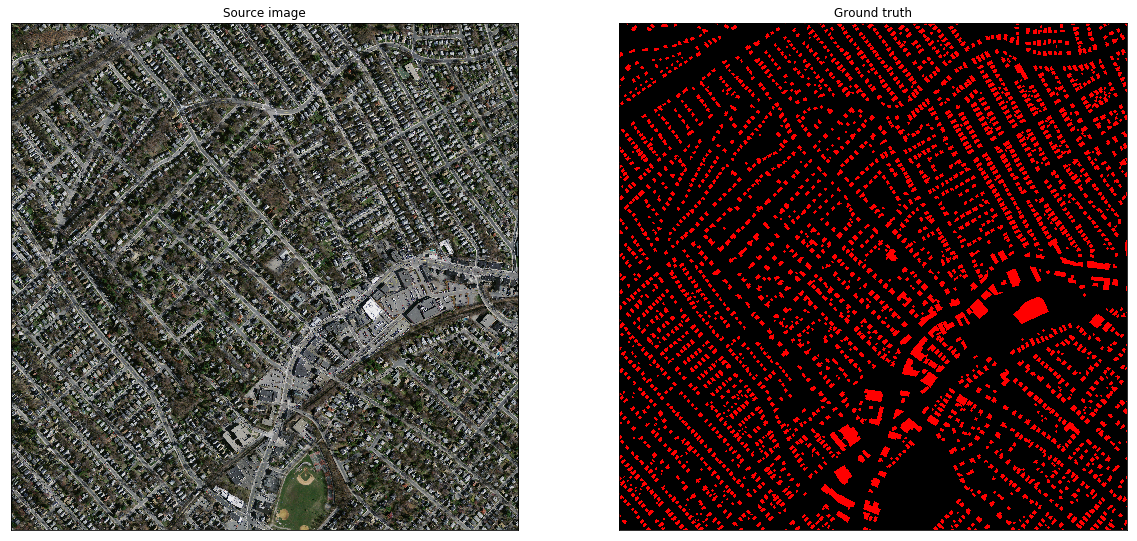

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fpath_image = './dataset/building_vmnih/test/image/22828930_15.tiff'
fpath_label = './dataset/building_vmnih/test/label/22828930_15.tif'

image = np.array(Image.open(fpath_image))
label = np.array(Image.open(fpath_label))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.imshow(image, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
fig.show()
ax.set_title('Source image')

ax = fig.add_subplot(122)
ax.imshow(label, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground truth')

fig.show()


In the dataset, 137 pairs of images and labels like above are provided for training. Before training models on the dataset, we explain some basics of pytorch.

##  Basics of PyTorch
PyTorch is a famous deep learning framework developed by Facebook. Here, we introduce the basics of PyTorch.

Now, import pytorch modules. <br>
`torch.nn` contains classes for various kinds of operations such as convolution, pooling, batchnormalization, etc.<br>
`torch.nn.functional` contains functions for basic (and non-parametric) operations such as activation functions.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Tensors in PyTorch
We can make tensors in many ways. Tensors can be used like numpy array.
```
torch.FloatTensor([1,2,3])
torch.from_numpy(ndarray)
torch.Tensor([1,2,3]).float()
```

### Basic operations
Before implementing network, we briefly check how to define basic operations like convolution or pooling. <br><br>

**Convolutional layer**<br>
convolutional layer is implemented as a class (`nn.Conv2d`). First create an instance of the layer, then use it like a function.
```
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
output = conv1(input)
```

**Pooling layer**
```
pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
output = pool1(input)

pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
output = pool2(input)
```

**Fully connected layer**
```
fc1 = torch.nn.Linear(in_features=128, out_features=128)
output = fc1(input)
```

**Activation functions**<br>
Activations are implemented as functions.
```
output = torch.nn.functional.relu(input)
```
We can also use class version.
```
act1 = torch.nn.ReLU()
output = act1(input)
```



### Defining network architecture
Using the basic operations mentioned above, we implement the VGG-like model which has $64\times64$ patches as inputs and output the estimation of center area of size $16\times16$.

In [3]:

class VGGS(nn.Module):
    def __init__(self):
        super(VGGS, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc6 = nn.Linear(in_features=4096, out_features=1024)
        self.fc7 = nn.Linear(in_features=1024, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.pool4(x)

        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        x = F.dropout(self.fc6(x))
        x = F.dropout(self.fc7(x))
        x = self.fc8(x)
        x = x.view(batch_size, 16, 16)
        return x
    
        

Create model, and check the architecture

In [4]:
model = VGGS()
print(model)

VGGS(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Lin

Check if the architecture is correct by processing random tensors.

In [5]:
inputs = np.random.randn(100,3,64,64).astype(np.float32)
inputs = torch.from_numpy(inputs)
output = model(inputs)
print(output.size())

torch.Size([100, 16, 16])


### Loss function
Here, we define cross entropy loss function for training. We need a small value `eps` to avoid overflow at `log()`.

In [6]:
import torch.nn.functional as F

class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        self.eps = 1.0e-7
        
    def forward(self, inputs, targets):
        prob = F.sigmoid(inputs)
        loss = -targets.float()*(prob + self.eps).log() - (1-targets.float())*(1 - prob + self.eps).log()
        loss = loss.mean()
        return loss


## Dataset and Dataloader
Bellow figure presents how mini-batches for training are created in PyTorch. <br>
**DataLoader**: DataLoader picks up data from Dataset and pack the collected data into mini-batch. <br>
**Dataset**: Dataset load and pre-process data requested from DataLoader. In some cases, we need to implement the Dataset custamized for our own data. <br>

<img src="./fig/pth_dataset.png">

### Define our own Dataset

In [7]:
import numpy as np
from torch.utils.data import Dataset

class Buildings(Dataset):
    def __init__(self, fpath_image_npy, fpath_label_npy):
        self.images = np.load(fpath_image_npy)
        self.labels = np.load(fpath_label_npy)
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        image = image.transpose([2,0,1])    # (H,W,B) to (B,H,W)
        
        image_tensor = torch.from_numpy(image).float()
        label_tensor = torch.from_numpy(label).long()
        
        return image_tensor, label_tensor
    
    def __len__(self):
        return len(self.images)
        
        
        
        

Load the building dataset

In [8]:
dataset = Buildings('./dataset/building_vmnih/train/patches/sat.npy', './dataset/building_vmnih/train/patches/map.npy')
image_tensor, label_tensor = dataset[0]
print(image_tensor.size())
print(label_tensor.size())
print(len(dataset))

torch.Size([3, 64, 64])
torch.Size([16, 16])
100


Then set DataLoader and check if it works. <br><br>
Arguments of init for DataLoader: <br>
batch_size: specify batch_size<br>
shuffle: if True, the data is randomly sampled from the Dataset and if False, the data is sequentially sampled.<br>
num_workers: number fo multi-thread workers. We can load data in parallel which will speed up dataloading.

In [21]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
for image, label in loader:
    print(image.size(), torch.mean(image).item())
    print(label.size(), label[0,0,0].item())
    print('')


torch.Size([10, 3, 64, 64]) 0.2463293969631195
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.12742896378040314
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.022673310711979866
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.37050116062164307
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.030102815479040146
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.0007643460994586349
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) -0.2542400062084198
torch.Size([10, 16, 16]) 0

torch.Size([10, 3, 64, 64]) 0.007535872980952263
torch.Size([10, 16, 16]) 1

torch.Size([10, 3, 64, 64]) 0.21779194474220276
torch.Size([10, 16, 16]) 1

torch.Size([10, 3, 64, 64]) -0.03216603770852089
torch.Size([10, 16, 16]) 1



### Training

Now, we prepared the training dataloader. In the following we briefly demonstrate training procedure. Since the full training takes much time, we just demonstrate first several iterations.

Set device. In this case, "cpu".

In [10]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

Set maximum epoch to train. For demonstration, we set the max_epochs 1, however we recommend to use tens of epochs.

In [11]:
max_epochs = 1

Transfer model to the device

In [12]:
model = model.to(device)

Set optimizer. Here, we use Adam.

In [13]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), weight_decay=1.0e-4)

Set loss function, and transfer it to the device.

In [14]:
criterion = Criterion().to(device)

Training iterations. We demonstrate only several iterations.

In [15]:
for epoch in range(max_epochs):
    for idx, (image, label) in enumerate(loader):
        image, label = image.to(device), label.to(device)
        
        # At the begining of each iteraton, clear accumulated gradient for the network parameters.
        optimizer.zero_grad()
        
        # Input the image to the model and get the prediction.
        output = model(image)
        
        # Calculate the loss function comparing the prediction and the ground truth
        loss = criterion(output, label)
        
        # Backpropagate the error signal through the model to calculate gradients.
        loss.backward()
        
        # Update the model parameters using the calculated gradients.
        optimizer.step()

        print('Epoch #%d, batch #%d: loss=%f' % (epoch, idx, loss.item()))
        
        # For demonstration, stop iteration at iter5
        if idx == 4:
            break


Epoch #0, batch #0: loss=0.693258


### Save the learned model

Set output directory

In [16]:
import os
output_dir = './learned_weights/'

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

Get the learned weights as dictionary.

In [19]:
dict_weights = model.state_dict()
for key, weight in dict_weights.items():
    print('%s\t%s' % (key, weight.size()))

conv1_1.weight	torch.Size([32, 3, 3, 3])
conv1_1.bias	torch.Size([32])
conv1_2.weight	torch.Size([32, 32, 3, 3])
conv1_2.bias	torch.Size([32])
conv2_1.weight	torch.Size([64, 32, 3, 3])
conv2_1.bias	torch.Size([64])
conv2_2.weight	torch.Size([64, 64, 3, 3])
conv2_2.bias	torch.Size([64])
conv3_1.weight	torch.Size([128, 64, 3, 3])
conv3_1.bias	torch.Size([128])
conv3_2.weight	torch.Size([128, 128, 3, 3])
conv3_2.bias	torch.Size([128])
conv4_1.weight	torch.Size([256, 128, 3, 3])
conv4_1.bias	torch.Size([256])
conv4_2.weight	torch.Size([256, 256, 3, 3])
conv4_2.bias	torch.Size([256])
fc6.weight	torch.Size([1024, 4096])
fc6.bias	torch.Size([1024])
fc7.weight	torch.Size([1024, 1024])
fc7.bias	torch.Size([1024])
fc8.weight	torch.Size([256, 1024])
fc8.bias	torch.Size([256])


Save the dictionary.

In [33]:
torch.save(dict_weights, output_dir + '/demo_building_vggs.torch')

### Inference

Settings. We will crop the test image by sliding the cropping window by stride of 16.

In [34]:
patch_size = 64
aoi_size = 16
stride = 16

<img src="./fig/fig_test_patch_small.png" width="300">

Prepare test area image

In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
import numpy as np

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

# Load image
fpath_test_image = './dataset/building_vmnih/test/image/22828930_15.tiff'
image = np.array(Image.open(fpath_test_image))
org_height, org_width, _ = image.shape

# Normalize
mean = np.mean(image, axis=(0,1), keepdims=True)
std = np.std(image, axis=(0,1), keepdims=True)
image = (image - mean) / std

# To tensor
image = image.transpose([2,0,1])    # Swap dimensions, (H,W,B) to (B,H,W)
image = image[np.newaxis,:,:,:]    # Add batch dimension (N,B,H,W)
image = torch.from_numpy(image).float()    # Convert to float tensor

Because the network outputs the estimation results of the center area of the input patches, to estimate the edge area of the image, a part of the input patch lies out of valid image region. Therefore we need expand the original image using some padding.

<img src="./fig/fig_test_padding_small.png" width="600">

In [36]:
# Reflection padding
pad_size = int((64-16)/2)
pad = nn.ReflectionPad2d(pad_size)
image = pad(image)
_, _, height, width = image.size()



Set model and load the trained weights

In [56]:
# Set model
model = VGGS().to(device)

# Load learned weights
learned_weights = torch.load('./learned_weights/demo_building_vggs.torch')
model.load_state_dict(learned_weights)

In [57]:

# Set place holder
prob_map = np.zeros([height, width])
count_map = np.zeros([height, width])

# Crop patches in sliding manner, and apply the prediction model
num_tiles_x = (width - patch_size) // stride + 2
num_tiles_y = (height - patch_size) // stride + 2

for iy in range(num_tiles_y):
    for ix in range(num_tiles_x):
        print('(%d/%d, %d/%d)' % (iy, num_tiles_y, ix, num_tiles_x))
        ulx = ix * stride
        uly = iy * stride
        lrx = ulx + patch_size
        lry = uly + patch_size
        
        if lrx > width:
            ulx = width - patch_size
            lrx = width
            
        if lry > height:
            uly = height - patch_size
            lry = height
            
        patch = image[:, :, uly:lry, ulx:lrx]
        patch = patch.to(device)
        
        logit = model(patch)
        prob = F.sigmoid(logit)
        
        stx = ulx + int((patch_size - aoi_size) / 2)
        sty = uly + int((patch_size - aoi_size) / 2)
        prob_map[sty:sty+aoi_size, stx:stx+aoi_size] += prob.detach().cpu().numpy().squeeze()
        count_map[sty:sty+aoi_size, stx:stx+aoi_size] += np.ones([aoi_size,aoi_size])

# Eliminate padded region
prob_map = prob_map[pad_size:pad_size+org_height, pad_size:pad_size+org_width]
count_map = count_map[pad_size:pad_size+org_height, pad_size:pad_size+org_width]

# Take average for overlaped regions
result = prob_map / count_map


(0/94, 0/94)
(0/94, 1/94)
(0/94, 2/94)
(0/94, 3/94)
(0/94, 4/94)
(0/94, 5/94)
(0/94, 6/94)
(0/94, 7/94)
(0/94, 8/94)
(0/94, 9/94)
(0/94, 10/94)
(0/94, 11/94)
(0/94, 12/94)
(0/94, 13/94)
(0/94, 14/94)
(0/94, 15/94)
(0/94, 16/94)
(0/94, 17/94)
(0/94, 18/94)
(0/94, 19/94)
(0/94, 20/94)
(0/94, 21/94)
(0/94, 22/94)
(0/94, 23/94)
(0/94, 24/94)
(0/94, 25/94)
(0/94, 26/94)
(0/94, 27/94)
(0/94, 28/94)
(0/94, 29/94)
(0/94, 30/94)
(0/94, 31/94)
(0/94, 32/94)
(0/94, 33/94)
(0/94, 34/94)
(0/94, 35/94)
(0/94, 36/94)
(0/94, 37/94)
(0/94, 38/94)
(0/94, 39/94)
(0/94, 40/94)
(0/94, 41/94)
(0/94, 42/94)
(0/94, 43/94)
(0/94, 44/94)
(0/94, 45/94)
(0/94, 46/94)
(0/94, 47/94)
(0/94, 48/94)
(0/94, 49/94)
(0/94, 50/94)
(0/94, 51/94)
(0/94, 52/94)
(0/94, 53/94)
(0/94, 54/94)
(0/94, 55/94)
(0/94, 56/94)
(0/94, 57/94)
(0/94, 58/94)
(0/94, 59/94)
(0/94, 60/94)
(0/94, 61/94)
(0/94, 62/94)
(0/94, 63/94)
(0/94, 64/94)
(0/94, 65/94)
(0/94, 66/94)
(0/94, 67/94)
(0/94, 68/94)
(0/94, 69/94)
(0/94, 70/94)
(0/94, 71/94)
(0

(6/94, 38/94)
(6/94, 39/94)
(6/94, 40/94)
(6/94, 41/94)
(6/94, 42/94)
(6/94, 43/94)
(6/94, 44/94)
(6/94, 45/94)
(6/94, 46/94)
(6/94, 47/94)
(6/94, 48/94)
(6/94, 49/94)
(6/94, 50/94)
(6/94, 51/94)
(6/94, 52/94)
(6/94, 53/94)
(6/94, 54/94)
(6/94, 55/94)
(6/94, 56/94)
(6/94, 57/94)
(6/94, 58/94)
(6/94, 59/94)
(6/94, 60/94)
(6/94, 61/94)
(6/94, 62/94)
(6/94, 63/94)
(6/94, 64/94)
(6/94, 65/94)
(6/94, 66/94)
(6/94, 67/94)
(6/94, 68/94)
(6/94, 69/94)
(6/94, 70/94)
(6/94, 71/94)
(6/94, 72/94)
(6/94, 73/94)
(6/94, 74/94)
(6/94, 75/94)
(6/94, 76/94)
(6/94, 77/94)
(6/94, 78/94)
(6/94, 79/94)
(6/94, 80/94)
(6/94, 81/94)
(6/94, 82/94)
(6/94, 83/94)
(6/94, 84/94)
(6/94, 85/94)
(6/94, 86/94)
(6/94, 87/94)
(6/94, 88/94)
(6/94, 89/94)
(6/94, 90/94)
(6/94, 91/94)
(6/94, 92/94)
(6/94, 93/94)
(7/94, 0/94)
(7/94, 1/94)
(7/94, 2/94)
(7/94, 3/94)
(7/94, 4/94)
(7/94, 5/94)
(7/94, 6/94)
(7/94, 7/94)
(7/94, 8/94)
(7/94, 9/94)
(7/94, 10/94)
(7/94, 11/94)
(7/94, 12/94)
(7/94, 13/94)
(7/94, 14/94)
(7/94, 15/94)
(7

(12/94, 53/94)
(12/94, 54/94)
(12/94, 55/94)
(12/94, 56/94)
(12/94, 57/94)
(12/94, 58/94)
(12/94, 59/94)
(12/94, 60/94)
(12/94, 61/94)
(12/94, 62/94)
(12/94, 63/94)
(12/94, 64/94)
(12/94, 65/94)
(12/94, 66/94)
(12/94, 67/94)
(12/94, 68/94)
(12/94, 69/94)
(12/94, 70/94)
(12/94, 71/94)
(12/94, 72/94)
(12/94, 73/94)
(12/94, 74/94)
(12/94, 75/94)
(12/94, 76/94)
(12/94, 77/94)
(12/94, 78/94)
(12/94, 79/94)
(12/94, 80/94)
(12/94, 81/94)
(12/94, 82/94)
(12/94, 83/94)
(12/94, 84/94)
(12/94, 85/94)
(12/94, 86/94)
(12/94, 87/94)
(12/94, 88/94)
(12/94, 89/94)
(12/94, 90/94)
(12/94, 91/94)
(12/94, 92/94)
(12/94, 93/94)
(13/94, 0/94)
(13/94, 1/94)
(13/94, 2/94)
(13/94, 3/94)
(13/94, 4/94)
(13/94, 5/94)
(13/94, 6/94)
(13/94, 7/94)
(13/94, 8/94)
(13/94, 9/94)
(13/94, 10/94)
(13/94, 11/94)
(13/94, 12/94)
(13/94, 13/94)
(13/94, 14/94)
(13/94, 15/94)
(13/94, 16/94)
(13/94, 17/94)
(13/94, 18/94)
(13/94, 19/94)
(13/94, 20/94)
(13/94, 21/94)
(13/94, 22/94)
(13/94, 23/94)
(13/94, 24/94)
(13/94, 25/94)
(13/9

(19/94, 51/94)
(19/94, 52/94)
(19/94, 53/94)
(19/94, 54/94)
(19/94, 55/94)
(19/94, 56/94)
(19/94, 57/94)
(19/94, 58/94)
(19/94, 59/94)
(19/94, 60/94)
(19/94, 61/94)
(19/94, 62/94)
(19/94, 63/94)
(19/94, 64/94)
(19/94, 65/94)
(19/94, 66/94)
(19/94, 67/94)
(19/94, 68/94)
(19/94, 69/94)
(19/94, 70/94)
(19/94, 71/94)
(19/94, 72/94)
(19/94, 73/94)
(19/94, 74/94)
(19/94, 75/94)
(19/94, 76/94)
(19/94, 77/94)
(19/94, 78/94)
(19/94, 79/94)
(19/94, 80/94)
(19/94, 81/94)
(19/94, 82/94)
(19/94, 83/94)
(19/94, 84/94)
(19/94, 85/94)
(19/94, 86/94)
(19/94, 87/94)
(19/94, 88/94)
(19/94, 89/94)
(19/94, 90/94)
(19/94, 91/94)
(19/94, 92/94)
(19/94, 93/94)
(20/94, 0/94)
(20/94, 1/94)
(20/94, 2/94)
(20/94, 3/94)
(20/94, 4/94)
(20/94, 5/94)
(20/94, 6/94)
(20/94, 7/94)
(20/94, 8/94)
(20/94, 9/94)
(20/94, 10/94)
(20/94, 11/94)
(20/94, 12/94)
(20/94, 13/94)
(20/94, 14/94)
(20/94, 15/94)
(20/94, 16/94)
(20/94, 17/94)
(20/94, 18/94)
(20/94, 19/94)
(20/94, 20/94)
(20/94, 21/94)
(20/94, 22/94)
(20/94, 23/94)
(20/9

(26/94, 39/94)
(26/94, 40/94)
(26/94, 41/94)
(26/94, 42/94)
(26/94, 43/94)
(26/94, 44/94)
(26/94, 45/94)
(26/94, 46/94)
(26/94, 47/94)
(26/94, 48/94)
(26/94, 49/94)
(26/94, 50/94)
(26/94, 51/94)
(26/94, 52/94)
(26/94, 53/94)
(26/94, 54/94)
(26/94, 55/94)
(26/94, 56/94)
(26/94, 57/94)
(26/94, 58/94)
(26/94, 59/94)
(26/94, 60/94)
(26/94, 61/94)
(26/94, 62/94)
(26/94, 63/94)
(26/94, 64/94)
(26/94, 65/94)
(26/94, 66/94)
(26/94, 67/94)
(26/94, 68/94)
(26/94, 69/94)
(26/94, 70/94)
(26/94, 71/94)
(26/94, 72/94)
(26/94, 73/94)
(26/94, 74/94)
(26/94, 75/94)
(26/94, 76/94)
(26/94, 77/94)
(26/94, 78/94)
(26/94, 79/94)
(26/94, 80/94)
(26/94, 81/94)
(26/94, 82/94)
(26/94, 83/94)
(26/94, 84/94)
(26/94, 85/94)
(26/94, 86/94)
(26/94, 87/94)
(26/94, 88/94)
(26/94, 89/94)
(26/94, 90/94)
(26/94, 91/94)
(26/94, 92/94)
(26/94, 93/94)
(27/94, 0/94)
(27/94, 1/94)
(27/94, 2/94)
(27/94, 3/94)
(27/94, 4/94)
(27/94, 5/94)
(27/94, 6/94)
(27/94, 7/94)
(27/94, 8/94)
(27/94, 9/94)
(27/94, 10/94)
(27/94, 11/94)
(27/9

(32/94, 64/94)
(32/94, 65/94)
(32/94, 66/94)
(32/94, 67/94)
(32/94, 68/94)
(32/94, 69/94)
(32/94, 70/94)
(32/94, 71/94)
(32/94, 72/94)
(32/94, 73/94)
(32/94, 74/94)
(32/94, 75/94)
(32/94, 76/94)
(32/94, 77/94)
(32/94, 78/94)
(32/94, 79/94)
(32/94, 80/94)
(32/94, 81/94)
(32/94, 82/94)
(32/94, 83/94)
(32/94, 84/94)
(32/94, 85/94)
(32/94, 86/94)
(32/94, 87/94)
(32/94, 88/94)
(32/94, 89/94)
(32/94, 90/94)
(32/94, 91/94)
(32/94, 92/94)
(32/94, 93/94)
(33/94, 0/94)
(33/94, 1/94)
(33/94, 2/94)
(33/94, 3/94)
(33/94, 4/94)
(33/94, 5/94)
(33/94, 6/94)
(33/94, 7/94)
(33/94, 8/94)
(33/94, 9/94)
(33/94, 10/94)
(33/94, 11/94)
(33/94, 12/94)
(33/94, 13/94)
(33/94, 14/94)
(33/94, 15/94)
(33/94, 16/94)
(33/94, 17/94)
(33/94, 18/94)
(33/94, 19/94)
(33/94, 20/94)
(33/94, 21/94)
(33/94, 22/94)
(33/94, 23/94)
(33/94, 24/94)
(33/94, 25/94)
(33/94, 26/94)
(33/94, 27/94)
(33/94, 28/94)
(33/94, 29/94)
(33/94, 30/94)
(33/94, 31/94)
(33/94, 32/94)
(33/94, 33/94)
(33/94, 34/94)
(33/94, 35/94)
(33/94, 36/94)
(33/9

(39/94, 58/94)
(39/94, 59/94)
(39/94, 60/94)
(39/94, 61/94)
(39/94, 62/94)
(39/94, 63/94)
(39/94, 64/94)
(39/94, 65/94)
(39/94, 66/94)
(39/94, 67/94)
(39/94, 68/94)
(39/94, 69/94)
(39/94, 70/94)
(39/94, 71/94)
(39/94, 72/94)
(39/94, 73/94)
(39/94, 74/94)
(39/94, 75/94)
(39/94, 76/94)
(39/94, 77/94)
(39/94, 78/94)
(39/94, 79/94)
(39/94, 80/94)
(39/94, 81/94)
(39/94, 82/94)
(39/94, 83/94)
(39/94, 84/94)
(39/94, 85/94)
(39/94, 86/94)
(39/94, 87/94)
(39/94, 88/94)
(39/94, 89/94)
(39/94, 90/94)
(39/94, 91/94)
(39/94, 92/94)
(39/94, 93/94)
(40/94, 0/94)
(40/94, 1/94)
(40/94, 2/94)
(40/94, 3/94)
(40/94, 4/94)
(40/94, 5/94)
(40/94, 6/94)
(40/94, 7/94)
(40/94, 8/94)
(40/94, 9/94)
(40/94, 10/94)
(40/94, 11/94)
(40/94, 12/94)
(40/94, 13/94)
(40/94, 14/94)
(40/94, 15/94)
(40/94, 16/94)
(40/94, 17/94)
(40/94, 18/94)
(40/94, 19/94)
(40/94, 20/94)
(40/94, 21/94)
(40/94, 22/94)
(40/94, 23/94)
(40/94, 24/94)
(40/94, 25/94)
(40/94, 26/94)
(40/94, 27/94)
(40/94, 28/94)
(40/94, 29/94)
(40/94, 30/94)
(40/9

(45/94, 58/94)
(45/94, 59/94)
(45/94, 60/94)
(45/94, 61/94)
(45/94, 62/94)
(45/94, 63/94)
(45/94, 64/94)
(45/94, 65/94)
(45/94, 66/94)
(45/94, 67/94)
(45/94, 68/94)
(45/94, 69/94)
(45/94, 70/94)
(45/94, 71/94)
(45/94, 72/94)
(45/94, 73/94)
(45/94, 74/94)
(45/94, 75/94)
(45/94, 76/94)
(45/94, 77/94)
(45/94, 78/94)
(45/94, 79/94)
(45/94, 80/94)
(45/94, 81/94)
(45/94, 82/94)
(45/94, 83/94)
(45/94, 84/94)
(45/94, 85/94)
(45/94, 86/94)
(45/94, 87/94)
(45/94, 88/94)
(45/94, 89/94)
(45/94, 90/94)
(45/94, 91/94)
(45/94, 92/94)
(45/94, 93/94)
(46/94, 0/94)
(46/94, 1/94)
(46/94, 2/94)
(46/94, 3/94)
(46/94, 4/94)
(46/94, 5/94)
(46/94, 6/94)
(46/94, 7/94)
(46/94, 8/94)
(46/94, 9/94)
(46/94, 10/94)
(46/94, 11/94)
(46/94, 12/94)
(46/94, 13/94)
(46/94, 14/94)
(46/94, 15/94)
(46/94, 16/94)
(46/94, 17/94)
(46/94, 18/94)
(46/94, 19/94)
(46/94, 20/94)
(46/94, 21/94)
(46/94, 22/94)
(46/94, 23/94)
(46/94, 24/94)
(46/94, 25/94)
(46/94, 26/94)
(46/94, 27/94)
(46/94, 28/94)
(46/94, 29/94)
(46/94, 30/94)
(46/9

(51/94, 78/94)
(51/94, 79/94)
(51/94, 80/94)
(51/94, 81/94)
(51/94, 82/94)
(51/94, 83/94)
(51/94, 84/94)
(51/94, 85/94)
(51/94, 86/94)
(51/94, 87/94)
(51/94, 88/94)
(51/94, 89/94)
(51/94, 90/94)
(51/94, 91/94)
(51/94, 92/94)
(51/94, 93/94)
(52/94, 0/94)
(52/94, 1/94)
(52/94, 2/94)
(52/94, 3/94)
(52/94, 4/94)
(52/94, 5/94)
(52/94, 6/94)
(52/94, 7/94)
(52/94, 8/94)
(52/94, 9/94)
(52/94, 10/94)
(52/94, 11/94)
(52/94, 12/94)
(52/94, 13/94)
(52/94, 14/94)
(52/94, 15/94)
(52/94, 16/94)
(52/94, 17/94)
(52/94, 18/94)
(52/94, 19/94)
(52/94, 20/94)
(52/94, 21/94)
(52/94, 22/94)
(52/94, 23/94)
(52/94, 24/94)
(52/94, 25/94)
(52/94, 26/94)
(52/94, 27/94)
(52/94, 28/94)
(52/94, 29/94)
(52/94, 30/94)
(52/94, 31/94)
(52/94, 32/94)
(52/94, 33/94)
(52/94, 34/94)
(52/94, 35/94)
(52/94, 36/94)
(52/94, 37/94)
(52/94, 38/94)
(52/94, 39/94)
(52/94, 40/94)
(52/94, 41/94)
(52/94, 42/94)
(52/94, 43/94)
(52/94, 44/94)
(52/94, 45/94)
(52/94, 46/94)
(52/94, 47/94)
(52/94, 48/94)
(52/94, 49/94)
(52/94, 50/94)
(52/9

(57/94, 76/94)
(57/94, 77/94)
(57/94, 78/94)
(57/94, 79/94)
(57/94, 80/94)
(57/94, 81/94)
(57/94, 82/94)
(57/94, 83/94)
(57/94, 84/94)
(57/94, 85/94)
(57/94, 86/94)
(57/94, 87/94)
(57/94, 88/94)
(57/94, 89/94)
(57/94, 90/94)
(57/94, 91/94)
(57/94, 92/94)
(57/94, 93/94)
(58/94, 0/94)
(58/94, 1/94)
(58/94, 2/94)
(58/94, 3/94)
(58/94, 4/94)
(58/94, 5/94)
(58/94, 6/94)
(58/94, 7/94)
(58/94, 8/94)
(58/94, 9/94)
(58/94, 10/94)
(58/94, 11/94)
(58/94, 12/94)
(58/94, 13/94)
(58/94, 14/94)
(58/94, 15/94)
(58/94, 16/94)
(58/94, 17/94)
(58/94, 18/94)
(58/94, 19/94)
(58/94, 20/94)
(58/94, 21/94)
(58/94, 22/94)
(58/94, 23/94)
(58/94, 24/94)
(58/94, 25/94)
(58/94, 26/94)
(58/94, 27/94)
(58/94, 28/94)
(58/94, 29/94)
(58/94, 30/94)
(58/94, 31/94)
(58/94, 32/94)
(58/94, 33/94)
(58/94, 34/94)
(58/94, 35/94)
(58/94, 36/94)
(58/94, 37/94)
(58/94, 38/94)
(58/94, 39/94)
(58/94, 40/94)
(58/94, 41/94)
(58/94, 42/94)
(58/94, 43/94)
(58/94, 44/94)
(58/94, 45/94)
(58/94, 46/94)
(58/94, 47/94)
(58/94, 48/94)
(58/9

(64/94, 81/94)
(64/94, 82/94)
(64/94, 83/94)
(64/94, 84/94)
(64/94, 85/94)
(64/94, 86/94)
(64/94, 87/94)
(64/94, 88/94)
(64/94, 89/94)
(64/94, 90/94)
(64/94, 91/94)
(64/94, 92/94)
(64/94, 93/94)
(65/94, 0/94)
(65/94, 1/94)
(65/94, 2/94)
(65/94, 3/94)
(65/94, 4/94)
(65/94, 5/94)
(65/94, 6/94)
(65/94, 7/94)
(65/94, 8/94)
(65/94, 9/94)
(65/94, 10/94)
(65/94, 11/94)
(65/94, 12/94)
(65/94, 13/94)
(65/94, 14/94)
(65/94, 15/94)
(65/94, 16/94)
(65/94, 17/94)
(65/94, 18/94)
(65/94, 19/94)
(65/94, 20/94)
(65/94, 21/94)
(65/94, 22/94)
(65/94, 23/94)
(65/94, 24/94)
(65/94, 25/94)
(65/94, 26/94)
(65/94, 27/94)
(65/94, 28/94)
(65/94, 29/94)
(65/94, 30/94)
(65/94, 31/94)
(65/94, 32/94)
(65/94, 33/94)
(65/94, 34/94)
(65/94, 35/94)
(65/94, 36/94)
(65/94, 37/94)
(65/94, 38/94)
(65/94, 39/94)
(65/94, 40/94)
(65/94, 41/94)
(65/94, 42/94)
(65/94, 43/94)
(65/94, 44/94)
(65/94, 45/94)
(65/94, 46/94)
(65/94, 47/94)
(65/94, 48/94)
(65/94, 49/94)
(65/94, 50/94)
(65/94, 51/94)
(65/94, 52/94)
(65/94, 53/94)
(65/9

(71/94, 31/94)
(71/94, 32/94)
(71/94, 33/94)
(71/94, 34/94)
(71/94, 35/94)
(71/94, 36/94)
(71/94, 37/94)
(71/94, 38/94)
(71/94, 39/94)
(71/94, 40/94)
(71/94, 41/94)
(71/94, 42/94)
(71/94, 43/94)
(71/94, 44/94)
(71/94, 45/94)
(71/94, 46/94)
(71/94, 47/94)
(71/94, 48/94)
(71/94, 49/94)
(71/94, 50/94)
(71/94, 51/94)
(71/94, 52/94)
(71/94, 53/94)
(71/94, 54/94)
(71/94, 55/94)
(71/94, 56/94)
(71/94, 57/94)
(71/94, 58/94)
(71/94, 59/94)
(71/94, 60/94)
(71/94, 61/94)
(71/94, 62/94)
(71/94, 63/94)
(71/94, 64/94)
(71/94, 65/94)
(71/94, 66/94)
(71/94, 67/94)
(71/94, 68/94)
(71/94, 69/94)
(71/94, 70/94)
(71/94, 71/94)
(71/94, 72/94)
(71/94, 73/94)
(71/94, 74/94)
(71/94, 75/94)
(71/94, 76/94)
(71/94, 77/94)
(71/94, 78/94)
(71/94, 79/94)
(71/94, 80/94)
(71/94, 81/94)
(71/94, 82/94)
(71/94, 83/94)
(71/94, 84/94)
(71/94, 85/94)
(71/94, 86/94)
(71/94, 87/94)
(71/94, 88/94)
(71/94, 89/94)
(71/94, 90/94)
(71/94, 91/94)
(71/94, 92/94)
(71/94, 93/94)
(72/94, 0/94)
(72/94, 1/94)
(72/94, 2/94)
(72/94, 3/94)

(78/94, 2/94)
(78/94, 3/94)
(78/94, 4/94)
(78/94, 5/94)
(78/94, 6/94)
(78/94, 7/94)
(78/94, 8/94)
(78/94, 9/94)
(78/94, 10/94)
(78/94, 11/94)
(78/94, 12/94)
(78/94, 13/94)
(78/94, 14/94)
(78/94, 15/94)
(78/94, 16/94)
(78/94, 17/94)
(78/94, 18/94)
(78/94, 19/94)
(78/94, 20/94)
(78/94, 21/94)
(78/94, 22/94)
(78/94, 23/94)
(78/94, 24/94)
(78/94, 25/94)
(78/94, 26/94)
(78/94, 27/94)
(78/94, 28/94)
(78/94, 29/94)
(78/94, 30/94)
(78/94, 31/94)
(78/94, 32/94)
(78/94, 33/94)
(78/94, 34/94)
(78/94, 35/94)
(78/94, 36/94)
(78/94, 37/94)
(78/94, 38/94)
(78/94, 39/94)
(78/94, 40/94)
(78/94, 41/94)
(78/94, 42/94)
(78/94, 43/94)
(78/94, 44/94)
(78/94, 45/94)
(78/94, 46/94)
(78/94, 47/94)
(78/94, 48/94)
(78/94, 49/94)
(78/94, 50/94)
(78/94, 51/94)
(78/94, 52/94)
(78/94, 53/94)
(78/94, 54/94)
(78/94, 55/94)
(78/94, 56/94)
(78/94, 57/94)
(78/94, 58/94)
(78/94, 59/94)
(78/94, 60/94)
(78/94, 61/94)
(78/94, 62/94)
(78/94, 63/94)
(78/94, 64/94)
(78/94, 65/94)
(78/94, 66/94)
(78/94, 67/94)
(78/94, 68/94)
(78

(84/94, 55/94)
(84/94, 56/94)
(84/94, 57/94)
(84/94, 58/94)
(84/94, 59/94)
(84/94, 60/94)
(84/94, 61/94)
(84/94, 62/94)
(84/94, 63/94)
(84/94, 64/94)
(84/94, 65/94)
(84/94, 66/94)
(84/94, 67/94)
(84/94, 68/94)
(84/94, 69/94)
(84/94, 70/94)
(84/94, 71/94)
(84/94, 72/94)
(84/94, 73/94)
(84/94, 74/94)
(84/94, 75/94)
(84/94, 76/94)
(84/94, 77/94)
(84/94, 78/94)
(84/94, 79/94)
(84/94, 80/94)
(84/94, 81/94)
(84/94, 82/94)
(84/94, 83/94)
(84/94, 84/94)
(84/94, 85/94)
(84/94, 86/94)
(84/94, 87/94)
(84/94, 88/94)
(84/94, 89/94)
(84/94, 90/94)
(84/94, 91/94)
(84/94, 92/94)
(84/94, 93/94)
(85/94, 0/94)
(85/94, 1/94)
(85/94, 2/94)
(85/94, 3/94)
(85/94, 4/94)
(85/94, 5/94)
(85/94, 6/94)
(85/94, 7/94)
(85/94, 8/94)
(85/94, 9/94)
(85/94, 10/94)
(85/94, 11/94)
(85/94, 12/94)
(85/94, 13/94)
(85/94, 14/94)
(85/94, 15/94)
(85/94, 16/94)
(85/94, 17/94)
(85/94, 18/94)
(85/94, 19/94)
(85/94, 20/94)
(85/94, 21/94)
(85/94, 22/94)
(85/94, 23/94)
(85/94, 24/94)
(85/94, 25/94)
(85/94, 26/94)
(85/94, 27/94)
(85/9

(90/94, 66/94)
(90/94, 67/94)
(90/94, 68/94)
(90/94, 69/94)
(90/94, 70/94)
(90/94, 71/94)
(90/94, 72/94)
(90/94, 73/94)
(90/94, 74/94)
(90/94, 75/94)
(90/94, 76/94)
(90/94, 77/94)
(90/94, 78/94)
(90/94, 79/94)
(90/94, 80/94)
(90/94, 81/94)
(90/94, 82/94)
(90/94, 83/94)
(90/94, 84/94)
(90/94, 85/94)
(90/94, 86/94)
(90/94, 87/94)
(90/94, 88/94)
(90/94, 89/94)
(90/94, 90/94)
(90/94, 91/94)
(90/94, 92/94)
(90/94, 93/94)
(91/94, 0/94)
(91/94, 1/94)
(91/94, 2/94)
(91/94, 3/94)
(91/94, 4/94)
(91/94, 5/94)
(91/94, 6/94)
(91/94, 7/94)
(91/94, 8/94)
(91/94, 9/94)
(91/94, 10/94)
(91/94, 11/94)
(91/94, 12/94)
(91/94, 13/94)
(91/94, 14/94)
(91/94, 15/94)
(91/94, 16/94)
(91/94, 17/94)
(91/94, 18/94)
(91/94, 19/94)
(91/94, 20/94)
(91/94, 21/94)
(91/94, 22/94)
(91/94, 23/94)
(91/94, 24/94)
(91/94, 25/94)
(91/94, 26/94)
(91/94, 27/94)
(91/94, 28/94)
(91/94, 29/94)
(91/94, 30/94)
(91/94, 31/94)
(91/94, 32/94)
(91/94, 33/94)
(91/94, 34/94)
(91/94, 35/94)
(91/94, 36/94)
(91/94, 37/94)
(91/94, 38/94)
(91/9

Check the estimation result

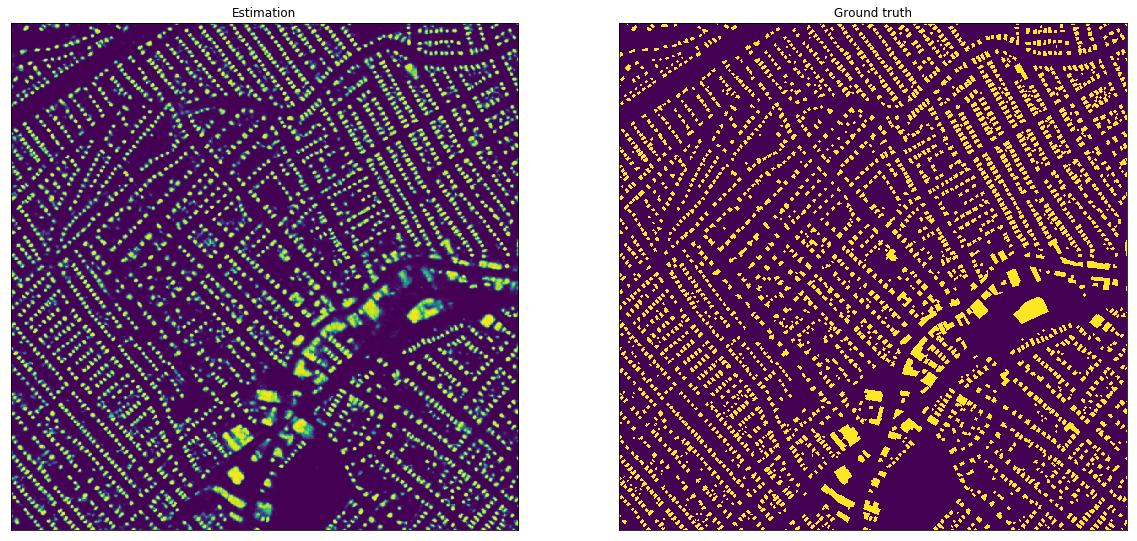

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fpath_test_label = './dataset/building_vmnih/test/label/22828930_15.tif'
label = np.array(Image.open(fpath_test_label))[:,:,0]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.imshow(result, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
fig.show()
ax.set_title('Estimation')

ax = fig.add_subplot(122)
ax.imshow(label, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground truth')

fig.show()


In [59]:
import numpy as np
pred = (result > 0.5)
label = (label > 0.5)

TP = np.sum(pred*label)
T = np.sum(label)
P = np.sum(pred)
IoU = float(TP) / (T+P-TP) * 100
print('IoU: %.2f%%' % IoU)

IoU: 59.07%


Next, we add data augmentation (random rotation and flipping) to our Dataset class.

In [40]:
import numpy as np
from torch.utils.data import Dataset
import random
from PIL import Image

class Buildings(Dataset):
    def __init__(self, fpath_image_npy, fpath_label_npy, augmentation=False):
        self.images = np.load(fpath_image_npy)
        self.labels = np.load(fpath_label_npy)
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        # Augmentation
        if self.augmentation:
            # Randomly choose rotation angle and flipping direction
            rotation = random.choice([0, 90, 180, 270])
            flip = random.choice(['H', 'V', 'N'])
            
            # Apply transformation for image
            image = self._rotate(image, rotation)
            image = np.array(self._flip(image, flip))

            # Also, apply the same transformation for label
            label = self._rotate(label, rotation)
            label = np.array(self._flip(label, flip))
        
        image = image.transpose([2,0,1])    # (H,W,B) to (B,H,W)
        
        image_tensor = torch.from_numpy(image).float()
        label_tensor = torch.from_numpy(label).long()
        
        return image_tensor, label_tensor
    
    def __len__(self):
        return len(self.images)
    
    # Rotation function
    def _rotate(self, image, rotation):
        if rotation == 0:
            return image
        elif rotation == 90:
            image = image.swapaxes(0,1)
            return np.flip(image, axis=0)
        elif rotation == 180:
            image = np.flip(image, axis=0)
            return np.flip(image, axis=1)
        elif rotation == 270:
            image = image.swapaxes(0,1)
            return np.flip(image, axis=1)
        else:
            raise RuntimeError

    # Flip function
    def _flip(self, image, direction):
        if direction == 'H':
            return np.flip(image, axis=1)
        elif direction == 'V':
            return np.flip(image, axis=0)
        elif direction == 'N':
            return image


Check the augmentation by sampling some patches from the Dataset.

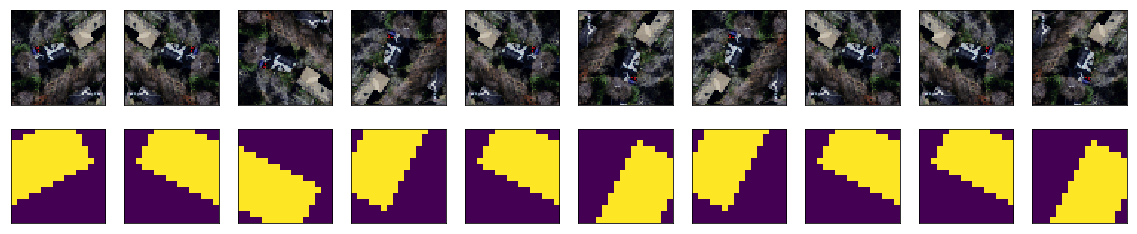

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from matplotlib.gridspec import GridSpec
grid = GridSpec(nrows=2, ncols=10)


mean = np.array([75, 75, 75])
std = np.array([50, 50, 50])

mean = mean[:, np.newaxis, np.newaxis]
std = std[:,np.newaxis, np.newaxis]

dataset = Buildings('./dataset/building_vmnih/train/patches/sat.npy', './dataset/building_vmnih/train/patches/map.npy', augmentation=True)

fig = plt.figure(figsize=(20,4))
for i in range(10):
    image_tensor, label_tensor = dataset[2]
    image_patch = image_tensor.detach().numpy() * std + mean
    label_patch = label_tensor.detach().numpy()
    
    image_patch = image_patch.transpose([1,2,0])
    image_patch = image_patch.clip(0,255).astype(np.uint8)

    ax = fig.add_subplot(grid[0,i])
    ax.imshow(image_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(grid[1,i])
    ax.imshow(label_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()

Such techniques are effective especially when we have limited amount of labeled data.
There are other methods which is 
- Transfer learning
- Data fusion
- Dilated convolutions
